# SfM using COLMAP

This primer is based on this notebook for pre-processing data for Nerfies: https://colab.research.google.com/github/google/nerfies/blob/main/notebooks/Nerfies_Capture_Processing.ipynb 

COLMAP is a SfM method which is widely used, it actually provides the "ground truth" data for many applications that require known camera poses -- such as NeRFs (https://www.matthewtancik.com/nerf, they will also be covered later in the course).

If you want to use COLMAP yourself (especially for larger datasets) it is recommended to install it locally rather than using colab. You can read more about COLMAP here: https://colmap.github.io/ and in its associated papers: https://openaccess.thecvf.com/content_cvpr_2016/papers/Schonberger_Structure-From-Motion_Revisited_CVPR_2016_paper.pdf and https://demuc.de/papers/schoenberger2016mvs.pdf (more the first one).

You should be roughly familiar with how COLMAP works from class. Here is the pipeline:

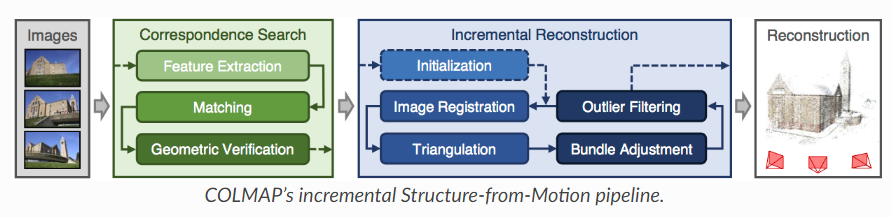

COLMAP splits this into three main modules which will be discussed in more detail below: 
- Feature detection and extraction

- Feature matching and geometric verification

- Structure and motion reconstruction


## Install dependencies.

In [ ]:
!apt-get install colmap ffmpeg

!pip install numpy==1.19.3
!pip install mediapipe
!pip install tensorflow_graphics
!pip install git+https://github.com/google/nerfies.git@v2
!pip install "git+https://github.com/google/nerfies.git#egg=pycolmap&subdirectory=third_party/pycolmap"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libamd2 libcamd2 libccolamd2 libceres1 libcholmod3 libcolamd2 libcxsparse3
  libfreeimage3 libgflags2.2 libglew2.0 libgoogle-glog0v5 libjxr0 libmetis5
  libraw16 libspqr2 libsuitesparseconfig5
Suggested packages:
  glew-utils
The following NEW packages will be installed:
  colmap libamd2 libcamd2 libccolamd2 libceres1 libcholmod3 libcolamd2
  libcxsparse3 libfreeimage3 libgflags2.2 libglew2.0 libgoogle-glog0v5 libjxr0
  libmetis5 libraw16 libspqr2 libsuitesparseconfig5
0 upgraded, 17 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,801 kB of archives.
After this operation, 19.1 MB of additional disk space will be used.
Get:1 http:/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 71.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 7.4 MB/s 
     |████████████████████████████████| 659 kB 61.0 MB/s 
     |████████████████████████████████| 281 kB 56.1 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
     |████████████████████████████████| 15.7 MB 37.0 MB/s 
  Created wheel for OpenEXR: filename=OpenEXR-1.3.9-cp37-cp37m-linux_x86_64.whl size=199482 sha256=29a8fc329e7fd57ee91a8b2e776a85799ec7f4a3e5eef55cd7e3bc9e9657b977
  Stored in directory: /root/.cache/pip/wheels/e3/31/09/2cb7b78bb1c4b2d44a6d11479c1bf7a66916253193e4f0eb90
Successfully built OpenEXR
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.3
    Uninstalling numpy-1.19.3:
      Successfully uninstalled numpy-1.19.3
  At

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/nerfies.git (to revision v2) to /tmp/pip-req-build-c1j40eud
  Running command git clone -q https://github.com/google/nerfies.git /tmp/pip-req-build-c1j40eud
  Running command git checkout -b v2 --track origin/v2
  Switched to a new branch 'v2'
  Branch 'v2' set up to track remote branch 'v2' from 'origin'.
  Created wheel for nerfies: filename=nerfies-0.0.2-py3-none-any.whl size=67946 sha256=0175be844831503de908494a8bc1291a52400041b6816887e5b65e4094dad4cd
  Stored in directory: /tmp/pip-ephem-wheel-cache-96qu3jzx/wheels/c4/1c/18/e23618842d95b1b52668d22c9514e33a85461ca40d13523a2b
Successfully built nerfies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/nerfies.git to /tmp/pip-install-5us07gcj/pycolmap_f78772e973ee427280304870a9a9297f
  Running command git clone -q htt

## Configuration.

Mount Google Drive onto `/content/gdrive`. You can skip this if you want to run this locally.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# @title Configure dataset directories
from pathlib import Path

# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = '/content/gdrive/Shareddrives/(TA Team Drive) CIS 580 Machine Perception Fall 2022/Worksheets/Primer 6: SfM with COLMAP/Data'  # @param {type: 'string'}
# @markdown The name of this capture. The working directory will be `$save_dir/$capture_name`. **Make sure you change this** when processing a new video.
capture_name = 'BenFranklin'  # @param {type: 'string'}
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'rgb-raw'
# Where to save the COLMAP outputs.
colmap_dir = root_dir / 'colmap'
colmap_db_path = colmap_dir / 'database.db'
colmap_out_path = colmap_dir / 'sparse'

colmap_out_path.mkdir(exist_ok=True, parents=True)
rgb_raw_dir.mkdir(exist_ok=True, parents=True)

print(f"""Directories configured:
  root_dir = {root_dir}
  rgb_raw_dir = {rgb_raw_dir}
  rgb_dir = {rgb_dir}
  colmap_dir = {colmap_dir}
""")

Directories configured:
  root_dir = /content/gdrive/Shareddrives/(TA Team Drive) CIS 580 Machine Perception Fall 2022/Worksheets/Primer 6: SfM with COLMAP/Data/BenFranklin
  rgb_raw_dir = /content/gdrive/Shareddrives/(TA Team Drive) CIS 580 Machine Perception Fall 2022/Worksheets/Primer 6: SfM with COLMAP/Data/BenFranklin/rgb-raw
  rgb_dir = /content/gdrive/Shareddrives/(TA Team Drive) CIS 580 Machine Perception Fall 2022/Worksheets/Primer 6: SfM with COLMAP/Data/BenFranklin/rgb
  colmap_dir = /content/gdrive/Shareddrives/(TA Team Drive) CIS 580 Machine Perception Fall 2022/Worksheets/Primer 6: SfM with COLMAP/Data/BenFranklin/colmap



## Dataset Processing.

### Load Video.

Download the benfranklin-compressed.mp4 video from the Data file and then upload it here. Or you can upload a video of your own and see how well it works.

In [ ]:
# @title Upload video file.
# @markdown Select a video file (.mp4, .mov, etc.) from your disk. This will upload it to the local Colab working directory.
from google.colab import files

uploaded = files.upload()

Saving benfranklin-compressed.mp4 to benfranklin-compressed.mp4


In [ ]:
# @title Flatten into images.

import cv2


# @markdown Flattens the video into images. The results will be saved to `rgb_raw_dir`.
video_path = next(iter(uploaded.keys()))

# @markdown Adjust `max_scale` to something smaller for faster processing.
max_scale = 0.5  # @param {type:'number'}
# @markdown A smaller FPS will be much faster for bundle adjustment, but at the expensive of a lower sampling density for training. For the paper we used ~15 fps but we default to something lower here to get you started faster.
# @markdown If given an fps of -1 we will try to auto-compute it.
fps = -1  # @param {type:'number'}
target_num_frames = 100 # @param {type: 'number'}

cap = cv2.VideoCapture(video_path)
input_fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if num_frames < target_num_frames:
  raise RuntimeError(
      'The video is too short and has fewer frames than the target.')

if fps == -1:
  fps = int(target_num_frames / num_frames * input_fps)
  print(f"Auto-computed FPS = {fps}")

# @markdown Check this if you want to reprocess the frames.
overwrite = False  # @param {type:'boolean'}

if (rgb_dir / '1x').exists() and not overwrite:
  raise RuntimeError(
      f'The RGB frames have already been processed. Check `overwrite` and run again if you really meant to do this.')
else:
  filters = f"mpdecimate,setpts=N/FRAME_RATE/TB,scale=iw*{max_scale}:ih*{max_scale}"
  tmp_rgb_raw_dir = 'rgb-raw'
  out_pattern = str('rgb-raw/%06d.png')
  !mkdir -p "$tmp_rgb_raw_dir"
  !ffmpeg -i "$video_path" -r $fps -vf $filters "$out_pattern"
  !mkdir -p "$rgb_raw_dir"
  !rsync -av "$tmp_rgb_raw_dir/" "$rgb_raw_dir/"

Auto-computed FPS = 7
ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enab

In [ ]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.
import concurrent.futures
import numpy as np
import cv2
import imageio
from PIL import Image


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1,2,4,8"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

tmp_rgb_dir = Path('rgb')

for image_path in Path(tmp_rgb_raw_dir).glob('*.png'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        tmp_rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))

!rsync -av "$tmp_rgb_dir/" "$rgb_dir/"

Saving rgb/1x/000024.png
Saving rgb/2x/000024.png
Saving rgb/4x/000024.png
Saving rgb/8x/000024.png
Saving rgb/1x/000091.png
Saving rgb/2x/000091.png
Saving rgb/4x/000091.png
Saving rgb/8x/000091.png
Saving rgb/1x/000054.png
Saving rgb/2x/000054.png
Saving rgb/4x/000054.png
Saving rgb/8x/000054.png
Saving rgb/1x/000080.png
Saving rgb/2x/000080.png
Saving rgb/4x/000080.png
Saving rgb/8x/000080.png
Saving rgb/1x/000093.png
Saving rgb/2x/000093.png
Saving rgb/4x/000093.png
Saving rgb/8x/000093.png
Saving rgb/1x/000046.png
Saving rgb/2x/000046.png
Saving rgb/4x/000046.png
Saving rgb/8x/000046.png
Saving rgb/1x/000064.png
Saving rgb/2x/000064.png
Saving rgb/4x/000064.png
Saving rgb/8x/000064.png
Saving rgb/1x/000025.png
Saving rgb/2x/000025.png
Saving rgb/4x/000025.png
Saving rgb/8x/000025.png
Saving rgb/1x/000047.png
Saving rgb/2x/000047.png
Saving rgb/4x/000047.png
Saving rgb/8x/000047.png
Saving rgb/1x/000095.png
Saving rgb/2x/000095.png
Saving rgb/4x/000095.png
Saving rgb/8x/000095.png


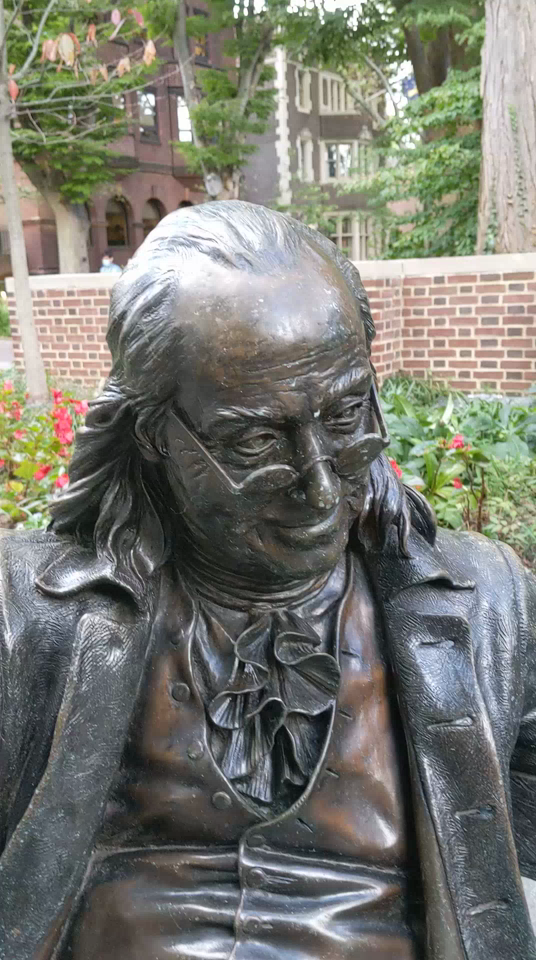

In [ ]:
# @title Example frame.
# @markdown Make sure that the video was processed correctly.
# @markdown If this gives an exception, try running the preceding cell one more time--sometimes uploading to Google Drive can fail.

from pathlib import Path
import imageio
from PIL import Image

image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

### Camera registration with COLMAP.

## Feature Extraction

The first step of Sfm is to extract features from the image.

Here the type of features used are SIFT features (Scale Invariant Feature transform)

There are mainly four steps involved in the SIFT algorithm.

1. Scale-space peak selection: Potential location for finding features.
2. Keypoint Localization: Accurately locating the feature keypoints.
3. Orientation Assignment: Assigning orientation to keypoints.
4. Keypoint descriptor: Describing the keypoints as a high dimensional vector.
5. Keypoint Matching

For more details about each of the step please refer to this article (https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40)


Intuitively SIFT features are scale invariant because they are extracted from the image pyramid which is formed by convolving with a gaussian kernel of different variance. Different variance means the blobs that would be extracted at each level would have a different scale. For example at a large variance small & sharp features would be blurred so what would remain are large features. Then as we know the scale of each of the feature extracted we can transform them in a canonical space where we can compare features from different images. This makes them scale invariant. As to the rotation invariance it is induced by finding the prinicpal orientation of the gradient in each patch. Then this is subtracted from every gradient in that image.

![picture](https://drive.google.com/uc?id=1i4hkg1NsmX7LWknlc_1hGEI7L2zOM2P_)

This video series beautifully explains SIFT features with visualisations. Highly recommended for intuitive understanding.
https://www.youtube.com/watch?v=KgsHoJYJ4S8



In [ ]:
# @title Extract features.
# @markdown Computes SIFT features and saves them to the COLMAP DB.
share_intrinsics = True  # @param {type: 'boolean'}
assume_upright_cameras = True  # @param {type: 'boolean'}

# @markdown This sets the scale at which we will run COLMAP. A scale of 1 will be more accurate but will be slow.
colmap_image_scale = 4  # @param {type: 'number'}
colmap_rgb_dir = rgb_dir / f'{colmap_image_scale}x'

# @markdown Check this if you want to re-process SfM.
overwrite = False  # @param {type: 'boolean'}

if overwrite and colmap_db_path.exists():
  colmap_db_path.unlink()

!colmap feature_extractor \
--SiftExtraction.use_gpu 0 \
--SiftExtraction.upright {int(assume_upright_cameras)} \
--ImageReader.camera_model OPENCV \
--ImageReader.single_camera {int(share_intrinsics)} \
--database_path "{str(colmap_db_path)}" \
--image_path "{str(colmap_rgb_dir)}"

## Feature matching

After detecting SIFT features from all of the images, we can find correspondence between images through a process called *feature matching*. Each feature is essentially a high-dimensional vector. You may consider the sets of features computed from two images, and compare the vectors in a nearest-neighbor fashion (by computing Euclidean distance between feature vectors) to find which features may correspond to the same object in both images. Because a feature in one image can sometimes look like multiple features in another image, [Lowe 2004] compared the two closest neighbors to determine whether to throw out a feature as unusable. More details of the process can be found on Wikipedia:
https://en.wikipedia.org/wiki/Scale-invariant_feature_transform#Feature_matching_and_indexing

In the below code, *exhaustive matching* refers to an exhaustive search through the entire dataste of images, comparing each image's features to all the other images' features. This would be too slow for datasets of thousands of images.

In *vocab tree matching*, each image is only compared to those images that are visually close to it. It uses something called a vocabulary tree with spatial re-ranking. The vocab tree comes pre-trained. The method comes from this paper:
https://www.researchgate.net/publication/307591406_A_Vote-and-Verify_Strategy_for_Fast_Spatial_Verification_in_Image_Retrieval

In [ ]:
# @title Match features.
# @markdown Match the SIFT features between images. Use `exhaustive` if you only have a few images and use `vocab_tree` if you have a lot of images.

match_method = 'exhaustive'  # @param ["exhaustive", "vocab_tree"]

if match_method == 'exhaustive':
  !colmap exhaustive_matcher \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"
else:
  # Use this if you have lots of frames.
  !wget https://demuc.de/colmap/vocab_tree_flickr100K_words32K.bin
  !colmap vocab_tree_matcher \
    --VocabTreeMatching.vocab_tree_path vocab_tree_flickr100K_words32K.bin \
    --SiftMatching.use_gpu 0 \
    --database_path "{str(colmap_db_path)}"


Exhaustive feature matching

Matching block [1/3, 1/3] in 36.350s
Matching block [1/3, 2/3] in 37.000s
Matching block [1/3, 3/3] in 0.000s
Matching block [2/3, 1/3] in 40.828s
Matching block [2/3, 2/3] in 36.617s
Matching block [2/3, 3/3] in 0.000s
Matching block [3/3, 1/3] in 1.415s
Matching block [3/3, 2/3] in 1.458s
Matching block [3/3, 3/3] in 0.000s
Elapsed time: 2.561 [minutes]


## Reconstruction

Now we run the reconstruction which will estimate the camera parameters for all the images using the feature matches we found above. These features allow us to align any two images with enough overlap by solving an optimization problem whose objective is to bring the corresponding points as much into alignment with each other as possible.

As we have multiple image pairs, COLMAP begin the reconstruction process by selecting an appropriate pair (this is important as a poor initialization can make the wole process fail). This allows as sparse point cloud (consisting of the detected feature points) to be formed. Additional images can then be registered to the pointcloud using PnP (note that they must have overlap with exisiting points in the pointcloud to do this).

To add new points to the pointcloud, they must be observed in at least two images which have been registered to the pointcloud (i.e. we must have two views of that scene point whose camera parameters we have estimated). It is necessary to have two because we don't have depth data. Finding the scene point like this is called triangulation. 

FInally, bundle adjustment jointly refines the estimated camera parameters and scene points. (Note that these variables are highly correlated but the above steps treated them seperately). 

In the below code block we define some parameters for COLMAP's reconstruction process. You can find a brief description of these and other COLMAP parameters along with their default values here: https://geeksrepos.com/mwtarnowski/colmap-parameters.
We modify 
* min_num_matches: The minimum number of matches for inlier matches to be considered.
* filter_max_reproj_error: Maximum reprojection error in pixels for observations.
* tri_complete_max_reproj_error: Maximum reprojection error to complete an existing triangulation.

These descriptions are pretty brief so you may want to play around with them to see the results. You can also modify some of the other parameters if you want (click on "Show code" and then you can modify it directly).

In [ ]:
# @title Reconstruction.
# @markdown Run structure-from-motion to compute camera parameters.

refine_principal_point = True  #@param {type:"boolean"}
min_num_matches =   32# @param {type: 'number'}
filter_max_reproj_error = 2  # @param {type: 'number'}
tri_complete_max_reproj_error = 2  # @param {type: 'number'}

!colmap mapper \
  --Mapper.ba_refine_principal_point {int(refine_principal_point)} \
  --Mapper.filter_max_reproj_error $filter_max_reproj_error \
  --Mapper.tri_complete_max_reproj_error $tri_complete_max_reproj_error \
  --Mapper.min_num_matches $min_num_matches \
  --database_path "{str(colmap_db_path)}" \
  --image_path "{str(colmap_rgb_dir)}" \
  --export_path "{str(colmap_out_path)}"

In [ ]:
# @title Verify that SfM worked.

if not colmap_db_path.exists():
  raise RuntimeError(f'The COLMAP DB does not exist, did you run the reconstruction?')
elif not (colmap_dir / 'sparse/0/cameras.bin').exists():
  raise RuntimeError("""
SfM seems to have failed. Try some of the following options:
 - Increase the FPS when flattenting to images. There should be at least 50-ish images.
 - Decrease `min_num_matches`.
 - If you images aren't upright, uncheck `assume_upright_cameras`.
""")
else:
  print("Everything looks good!")

Everything looks good!


## Parse Data.

In [ ]:
# @title Define Scene Manager.
from absl import logging
from typing import Dict
import numpy as np
from nerfies.camera import Camera
import pycolmap
from pycolmap import Quaternion


def convert_colmap_camera(colmap_camera, colmap_image):
  """Converts a pycolmap `image` to an SFM camera."""
  camera_rotation = colmap_image.R()
  camera_position = -(colmap_image.t @ camera_rotation)
  new_camera = Camera(
      orientation=camera_rotation,
      position=camera_position,
      focal_length=colmap_camera.fx,
      pixel_aspect_ratio=colmap_camera.fx / colmap_camera.fx,
      principal_point=np.array([colmap_camera.cx, colmap_camera.cy]),
      radial_distortion=np.array([colmap_camera.k1, colmap_camera.k2, 0.0]),
      tangential_distortion=np.array([colmap_camera.p1, colmap_camera.p2]),
      skew=0.0,
      image_size=np.array([colmap_camera.width, colmap_camera.height])
  )
  return new_camera


def filter_outlier_points(points, inner_percentile):
  """Filters outlier points."""
  outer = 1.0 - inner_percentile
  lower = outer / 2.0
  upper = 1.0 - lower
  centers_min = np.quantile(points, lower, axis=0)
  centers_max = np.quantile(points, upper, axis=0)
  result = points.copy()

  too_near = np.any(result < centers_min[None, :], axis=1)
  too_far = np.any(result > centers_max[None, :], axis=1)

  return result[~(too_near | too_far)]


def average_reprojection_errors(points, pixels, cameras):
  """Computes the average reprojection errors of the points."""
  cam_errors = []
  for i, camera in enumerate(cameras):
    cam_error = reprojection_error(points, pixels[:, i], camera)
    cam_errors.append(cam_error)
  cam_error = np.stack(cam_errors)

  return cam_error.mean(axis=1)


def _get_camera_translation(camera):
  """Computes the extrinsic translation of the camera."""
  rot_mat = camera.orientation
  return -camera.position.dot(rot_mat.T)


def _transform_camera(camera, transform_mat):
  """Transforms the camera using the given transformation matrix."""
  # The determinant gives us volumetric scaling factor.
  # Take the cube root to get the linear scaling factor.
  scale = np.cbrt(linalg.det(transform_mat[:, :3]))
  quat_transform = ~Quaternion.FromR(transform_mat[:, :3] / scale)

  translation = _get_camera_translation(camera)
  rot_quat = Quaternion.FromR(camera.orientation)
  rot_quat *= quat_transform
  translation = scale * translation - rot_quat.ToR().dot(transform_mat[:, 3])
  new_transform = np.eye(4)
  new_transform[:3, :3] = rot_quat.ToR()
  new_transform[:3, 3] = translation

  rotation = rot_quat.ToR()
  new_camera = camera.copy()
  new_camera.orientation = rotation
  new_camera.position = -(translation @ rotation)
  return new_camera


def _pycolmap_to_sfm_cameras(manager: pycolmap.SceneManager) -> Dict[int, Camera]:
  """Creates SFM cameras."""
  # Use the original filenames as indices.
  # This mapping necessary since COLMAP uses arbitrary numbers for the
  # image_id.
  image_id_to_colmap_id = {
      image.name.split('.')[0]: image_id
      for image_id, image in manager.images.items()
  }

  sfm_cameras = {}
  for image_id in image_id_to_colmap_id:
    colmap_id = image_id_to_colmap_id[image_id]
    image = manager.images[colmap_id]
    camera = manager.cameras[image.camera_id]
    sfm_cameras[image_id] = convert_colmap_camera(camera, image)

  return sfm_cameras


class SceneManager:
  """A thin wrapper around pycolmap."""

  @classmethod
  def from_pycolmap(cls, colmap_path, image_path, min_track_length=10):
    """Create a scene manager using pycolmap."""
    manager = pycolmap.SceneManager(str(colmap_path))
    manager.load_cameras()
    manager.load_images()
    manager.load_points3D()
    manager.filter_points3D(min_track_len=min_track_length)
    sfm_cameras = _pycolmap_to_sfm_cameras(manager)
    return cls(sfm_cameras, manager.get_filtered_points3D(), image_path)

  def __init__(self, cameras, points, image_path):
    self.image_path = Path(image_path)
    self.camera_dict = cameras
    self.points = points

    logging.info('Created scene manager with %d cameras', len(self.camera_dict))

  def __len__(self):
    return len(self.camera_dict)

  @property
  def image_ids(self):
    return sorted(self.camera_dict.keys())

  @property
  def camera_list(self):
    return [self.camera_dict[i] for i in self.image_ids]

  @property
  def camera_positions(self):
    """Returns an array of camera positions."""
    return np.stack([camera.position for camera in self.camera_list])

  def load_image(self, image_id):
    """Loads the image with the specified image_id."""
    path = self.image_path / f'{image_id}.png'
    with path.open('rb') as f:
      return imageio.imread(f)

  def triangulate_pixels(self, pixels):
    """Triangulates the pixels across all cameras in the scene.

    Args:
      pixels: the pixels to triangulate. There must be the same number of pixels
        as cameras in the scene.

    Returns:
      The 3D points triangulated from the pixels.
    """
    if pixels.shape != (len(self), 2):
      raise ValueError(
          f'The number of pixels ({len(pixels)}) must be equal to the number '
          f'of cameras ({len(self)}).')

    return triangulate_pixels(pixels, self.camera_list)

  def change_basis(self, axes, center):
    """Change the basis of the scene.

    Args:
      axes: the axes of the new coordinate frame.
      center: the center of the new coordinate frame.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    transform_mat = np.zeros((3, 4))
    transform_mat[:3, :3] = axes.T
    transform_mat[:, 3] = -(center @ axes)
    return self.transform(transform_mat)

  def transform(self, transform_mat):
    """Transform the scene using a transformation matrix.

    Args:
      transform_mat: a 3x4 transformation matrix representation a
        transformation.

    Returns:
      A new SceneManager with transformed points and cameras.
    """
    if transform_mat.shape != (3, 4):
      raise ValueError('transform_mat should be a 3x4 transformation matrix.')

    points = None
    if self.points is not None:
      points = self.points.copy()
      points = points @ transform_mat[:, :3].T + transform_mat[:, 3]

    new_cameras = {}
    for image_id, camera in self.camera_dict.items():
      new_cameras[image_id] = _transform_camera(camera, transform_mat)

    return SceneManager(new_cameras, points, self.image_path)

  def filter_images(self, image_ids):
    num_filtered = 0
    for image_id in image_ids:
      if self.camera_dict.pop(image_id, None) is not None:
        num_filtered += 1

    return num_filtered


In [ ]:
# @title Load COLMAP scene.
import plotly.graph_objs as go

scene_manager = SceneManager.from_pycolmap(
    colmap_dir / 'sparse/0', 
    rgb_dir / f'1x', 
    min_track_length=5)

if colmap_image_scale > 1:
  print(f'Scaling COLMAP cameras back to 1x from {colmap_image_scale}x.')
  for item_id in scene_manager.image_ids:
    camera = scene_manager.camera_dict[item_id]
    scene_manager.camera_dict[item_id] = camera.scale(colmap_image_scale)


fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=scene_manager.points[:, 0],
    y=scene_manager.points[:, 1],
    z=scene_manager.points[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.add_trace(go.Scatter3d(
    x=scene_manager.camera_positions[:, 0],
    y=scene_manager.camera_positions[:, 1],
    z=scene_manager.camera_positions[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.update_layout(scene_dragmode='orbit')
fig.show()

Scaling COLMAP cameras back to 1x from 4x.


To make the shape of the head more visible we crop the plot to just the area near the camera. The unshown points are just points in the background which were detected.

In [ ]:
# @title Load COLMAP scene.
import plotly.graph_objs as go

scene_manager = SceneManager.from_pycolmap(
    colmap_dir / 'sparse/0', 
    rgb_dir / f'1x', 
    min_track_length=5)

if colmap_image_scale > 1:
  print(f'Scaling COLMAP cameras back to 1x from {colmap_image_scale}x.')
  for item_id in scene_manager.image_ids:
    camera = scene_manager.camera_dict[item_id]
    scene_manager.camera_dict[item_id] = camera.scale(colmap_image_scale)


fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=scene_manager.points[:, 0],
    y=scene_manager.points[:, 1],
    z=scene_manager.points[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.add_trace(go.Scatter3d(
    x=scene_manager.camera_positions[:, 0],
    y=scene_manager.camera_positions[:, 1],
    z=scene_manager.camera_positions[:, 2],
    mode='markers',
    marker=dict(size=2),
))
fig.update_layout(scene_dragmode='orbit')
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-20,20],),
                     yaxis = dict(nticks=4, range=[-20,20],),
                     zaxis = dict(nticks=4, range=[-20,20],),))
fig.update_layout(scene_aspectmode='cube')
fig.show()

Scaling COLMAP cameras back to 1x from 4x.
